In [9]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

Load data

In [8]:
# Load the train/val/test dataset
df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


Model Implementation

In [11]:
def gini(sequence):
    _, count=np.unique(sequence,return_counts=True)
    p=count/len(sequence)
    return 1-np.sum(p**2)


def entropy(sequence):
    _, count=np.unique(sequence,return_counts=True)
    p=count/len(sequence)
    return -1*np.sum(p*np.log(p))

In [12]:
class Tree():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self,feature_index=None,threshold=None,value=None,left_child=None,right_child=None):
        self.feature_index = feature_index  # 該node要用哪個feature決定
        self.threshold = threshold  # threshold value for feature split
        self.value = value  # value if node is a leaf in the tree
        self.left_child = left_child  # left subtree
        self.right_child = right_child  # right subtree

In [19]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        
        """
            You can add/change any variables/methods to meet your need.
        """
        #decide criterion
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        #decide max depth of tree
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth
        self.max_features=max_features # 有多少features
        self.tree=None #存最後的結果 best_feature & best_threshold
        self.importance = {}
    
    def fit(self, X, y):
        if self.max_features is None:
            self.max_features=X.shape[1] #一共有多少features
        self.importance=np.zeros(X.shape[1])   
        self.tree=self.build_tree(X,y) #build tree
    
    def build_tree(self,X,y,depth=0):
        n_sample,n_features=X.shape #n_sample=total數量, n_features=total feature數
        n_classes=len(np.unique(y)) #有多少classes
        
        # Stop building tree if max_depth is reached
        if self.max_depth and depth>=self.max_depth: 
            leaf_value=np.bincount(y.astype(int)).argmax()
            return Tree(value=leaf_value)
        # Stop building ree if there is only one class
        if n_classes==1:
            return Tree(value=y[0])
        
        # Find the best split
        best_feature, best_threshold = self.best_split(X,y)
        if best_threshold is None:
            leaf_value=np.bincount(y.astype(int)).argmax()
            return Tree(value=leaf_value)
        left_indexs=X[:,best_feature]<best_threshold
        right_indexs=X[:,best_feature]>=best_threshold
        
        # Stop building tree if there is no split
        if len(left_indexs)==0 or len(right_indexs)==0:
            leaf_value=np.bincount(y.astype(int)).argmax()
            return Tree(value=leaf_value)
        
        # Build left and right subtrees
        left_tree=self.build_tree(X[left_indexs],y[left_indexs],depth+1)
        right_tree=self.build_tree(X[right_indexs],y[right_indexs],depth+1)
        
        # return the decision node
        return Tree(feature_index=best_feature, threshold=best_threshold, left_child=left_tree, right_child=right_tree)
    def best_split(self,X,y):
        best_criterion=np.inf
        best_feature,best_threshold=None,None
        for feature in range(self.max_features):
            thresholds=np.sort(X[:,feature], axis=-1, kind=None, order=None)
            for i in range(1,X.shape[0]):
                threshold=(thresholds[i-1]+thresholds[i])/2
                left_indexs=X[:,feature]<threshold
                right_indexs=X[:,feature]>= threshold
                n_left=np.count_nonzero(left_indexs)
                n_right=np.count_nonzero(right_indexs)
                if n_left==0 or n_right==0:
                    continue
                # Calculate the criterion for the split
                left_criterion=self.criterion(y[left_indexs])
                right_criterion=self.criterion(y[right_indexs])
                criterion=(n_left*left_criterion+n_right*right_criterion)/(n_left + n_right)
                # Update best split
                if criterion<best_criterion:
                    best_criterion=criterion
                    best_feature=feature
                    best_threshold=threshold
        return best_feature, best_threshold
    def predict(self, X):
        return [self.traverse(x) for x in X]
    def traverse(self, x):
        node = self.tree
        while node.feature_index is not None:
            if x[node.feature_index]<node.threshold:
                node=node.left_child
            else:
                node=node.right_child
        return node.value
    def get_features(self,tree):
        if tree.feature_index is not None:
            self.get_features(tree.left_child)
            self.importance[tree.feature_index]+=1     
        if tree.feature_index is not None:
            self.get_features(tree.right_child)
            self.importance[tree.feature_index]+=1           
    def countImportance(self):
        self.importance=np.zeros(7).astype(int)  
        node=self.tree
        self.get_features(node)
        return self.importance

In [14]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        self.max_features = None
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        if max_features is None:
            self.max_features=7
        else:
            self.max_features = int(round(max_features))
        self.forest=[]
        for i in range(self.n_estimators):
            self.forest.append(DecisionTree(self.criterion,self.max_depth,self.max_depth))
        self.random_features = []
    def fit(self, X, y):
        for i in range(self.n_estimators):
            random_feature = np.random.choice(np.arange(X.shape[1]),size= self.max_features,replace=False)
            self.random_features.append(random_feature)
            if self.boostrap:
                sample_num = int(np.round(X.shape[0]*2/3))
                subset_index=np.random.choice(np.arange(X.shape[0]),size= sample_num,replace=False)
                self.forest[i].fit(X[subset_index][:,random_feature],y[subset_index])
            else:
                self.forest[i].fit(X[:,random_feature],y)
    def predict(self, X):
        # majority vote
        pred = np.zeros(X.shape[0]).astype(np.int32)
        correct=0
        for i in range(X.shape[0]):
            vote=[]
            for j in range(self.n_estimators):
                vote.append(self.forest[j].traverse(X[i,self.random_features[j]]))
            label, count= np.unique(vote, return_counts=True)
            pred[i]=label[np.argmax(count)]
        return pred

Questions for Decision Tree

In [8]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.45056120886630463
['+' '+' '+' '-' '-' '-']: entropy = 0.6931471805599453
['+' '-' '-' '-' '-' '-']: entropy = 0.45056120886630463

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [16]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)
#3 5 3 3 6 2 2 4

Q2-1 max_depth=3:  0.73125


In [15]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))
assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

NameError: name 'acc' is not defined

In [17]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.86375


In [12]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))

Q3-1 criterion='gini':  0.73125


In [13]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.7725


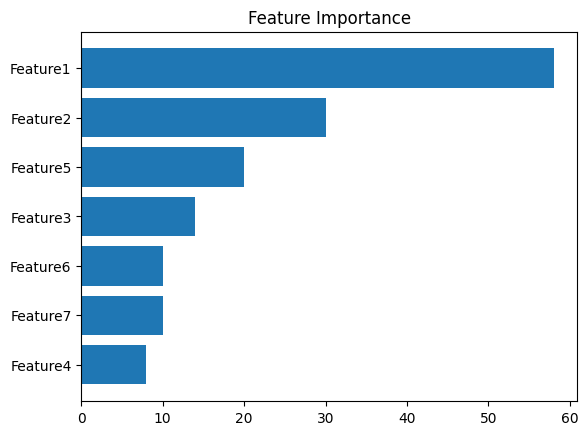

In [20]:
# For Q4
# Use simply counting to get the feature importance: dt_depth10.importance
labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']
values=dt_depth10.countImportance()
sorted_indexes = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
sorted_values = [values[i] for i in sorted_indexes]
sorted_labels = [labelList[i] for i in sorted_indexes]
plt.title('Feature Importance')
plt.barh(range(len(values)), sorted_values[::-1])
plt.yticks(range(len(values)), sorted_labels[::-1])
plt.show()

Questions for Random Rorest

In [15]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(7)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q6-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q6-1 n_estimators=10:  0.88


In [16]:
# For Q6-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(0)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q6-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q6-1 n_estimators=50:  0.89125


In [17]:
# For Q7-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(7)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q7-1 max_features='sqrt':  0.88


In [18]:
# For Q7-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q7-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q7-1 max_features='All':  0.88375


Train your own model

In [ ]:
# Build and train your model

In [47]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_vals  = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv" ,nrows=200))
#X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
#y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

merged_df = pd.concat([df_train, df_vals], ignore_index=True)

X_train = merged_df[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = merged_df["Target"].to_numpy()


In [48]:
X_train.shape

(1000, 7)

In [50]:
np.random.seed(33)
my_model = RandomForest(n_estimators=150, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
my_model.fit(X_train, y_train)
print("n_estimators=150: ", accuracy_score(y_val,my_model.predict(X_val)))

n_estimators=150:  0.925


In [16]:
test_pred = my_model.predict(X_test)

print("test_pred shape: ", test_pred.shape)

test_pred shape:  (800,)


In [17]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("311553046_prediction2.csv")